In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mplcursors
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util.f_ring import (compute_corrected_ew, 
                                fit_hg_phase_function, 
                                hg_func,
                                print_hg_params)

%matplotlib notebook

# Utility Functions

In [2]:
### READ EW STATS AND OBS_LIST RESTRICTIONS

def read_obs_list():
    global OBS_LIST
    OBS_LIST = pd.read_csv('../obs_list.csv', parse_dates=['Date'], index_col='Observation')
    
def read_ew_stats(filename):
    obsdata = pd.read_csv(filename, parse_dates=['Date'])
    obsdata = obsdata.join(OBS_LIST, on='Observation', rsuffix='_obslist')
    obsdata = obsdata[obsdata['For Photometry'] == 1]
    print(f'** SUMMARY STATISTICS - {filename} **')
    print('Unique observation names:', len(obsdata.groupby('Observation')))
    print('Total slices:', len(obsdata))
    print('Starting date:', obsdata['Date'].min())
    print('Ending date:', obsdata['Date'].max())
    print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
    obsdata['Mu'] = np.abs(np.cos(np.radians(obsdata['Mean Emission'])))
    obsdata['Mu0'] = np.abs(np.cos(np.radians(obsdata['Incidence'])))
    return obsdata


### SINGLE PLOTS ON AN AXIS - PHASE CURVE

def _standard_alpha(obsdata):
    """Return alpha based on number of points to plot."""
    if len(obsdata) < 1000:
        return 1
    elif len(obsdata) < 10000:
        return 0.6
    else:
        return 0.3

def _add_hover(obsdata, p):
    """Add hover text to scatter points."""
    cursor = mplcursors.cursor(p, hover=True)
    @cursor.connect('add')
    def on_add(sel):
        row = obsdata.iloc[sel.target.index]
        sel.annotation.set(text=f"{row['Observation']} @ {row['Min Long']:.2f}\n"
                                f"(a={row['Mean Phase']:.0f}, e={row['Mean Emission']:.0f}, "
                                f"i={row['Incidence']:.2f})")
        
def plot_points_phase_curve(ax, obsdata, params, used_obsdata=None):
    """Plot scattered used/unused EW points and fit phase curve."""
    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    
    if used_obsdata is not None:
        used_obsdata['Phase Model'] = hg_func(params, used_obsdata['Mean Phase'])
        obsdata['_alpha'] = 0.1
        obsdata['_color'] = 'red'
        obsdata.loc[used_obsdata.index, '_alpha'] = 0.3
        obsdata.loc[used_obsdata.index, '_color'] = 'black'
    else:
        obsdata['_alpha'] = 0.3
        obsdata['_color'] = 'black'
        
    p = ax.scatter(obsdata['Mean Phase'], obsdata['Normal EW'], marker='o', 
                   s=5, color=obsdata['_color'], alpha=obsdata['_alpha'])
    _add_hover(obsdata, p)

    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax.set_yscale('log')
    ax.set_xlim(0, 180)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel('Normal EW')

def plot_heatmap_phase_curve(ax, obsdata, params):
    """Plot binned heatmap and fit phase curve."""
    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    ymin = obsdata['Normal EW'].min()
    ymax = obsdata['Normal EW'].max()
    heatmap, xedges, yedges = np.histogram2d(obsdata['Mean Phase'],
                                             np.log10(obsdata['Normal EW']),
                                             bins=(90, 50),
                                             range=[[0,180], [np.log10(ymin), np.log10(ymax)]])
    heatmap = heatmap ** .25
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T[::-1,:], extent=extent, cmap=cm.Greys, interpolation='nearest', aspect='auto')
    
    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, np.log10(full_phase_model), '-', color='green', lw=2)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel('Normal EW')
    
def plot_points_phase_time(ax, obsdata, params, time_fit=3):
    """Plot scattered EW points by time with fit time curve colored by phase."""
    time0 = np.datetime64('1970-01-01T00:00:00') # epoch
    obsdata['Date_secs'] = (obsdata['Date']-time0).dt.total_seconds()/86400
    obsdata['Phase Curve Ratio'] = obsdata['Normal EW'] / obsdata['Phase Model']
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata['Date'], obsdata['Phase Curve Ratio'], marker='o', s=5,
                   c=obsdata['Mean Phase'], cmap=cm.jet, alpha=alpha)
    _add_hover(obsdata, p)

    timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], time_fit)
    timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
    timefit = np.polyval(timecoeff, timerange)
    ax.plot(timerange, timefit, '-', lw=2, color='green')
    ax.set_yscale('log')
    ax.set_xlabel('Date of Observation')
    ax.set_ylabel('Normal EW / Full Phase Model')

    
def plot_points_phase_curve_time(obsdata, params, title, used_obsdata=None, time_fit=3):
    """Plot 1) scatter+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_points_phase_curve(axs[0], obsdata, params, used_obsdata=used_obsdata)
    plot_points_phase_time(axs[1], obsdata, params, time_fit=time_fit)
    plt.suptitle(title)
    plt.tight_layout()
    
def plot_heatmap_phase_curve_time(obsdata, params, title, time_fit=3):
    """Plot 1) heatmap+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_heatmap_phase_curve(axs[0], obsdata, params)
    plot_points_phase_time(axs[1], obsdata, params, time_fit=time_fit)
    plt.suptitle(title)
    plt.tight_layout()
    
    
### SINGLE PLOTS ON AN AXIS - RATIOS

def plot_ratio_vs(ax, obsdata, params, vs, color_by, order):
    """Plot scattered used/unused EW points vs. another parameter."""
    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    obsdata['Phase Curve Ratio'] = obsdata['Normal EW'] / obsdata['Phase Model']
    
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata[vs], obsdata['Phase Curve Ratio'], marker='o', 
                   s=5, c=obsdata[color_by], cmap=cm.jet, alpha=alpha)
    _add_hover(obsdata, p)

    coeff = np.polyfit(obsdata[vs], obsdata['Phase Curve Ratio'], order)
    xrange = np.linspace(obsdata[vs].min(), obsdata[vs].max(), 100, endpoint=True)
    fit = np.polyval(coeff, xrange)
    ax.plot(xrange, fit, '-', lw=2, color='green')

    ax.set_yscale('log')
    ax.set_xlabel(vs)
    ax.set_ylabel('Normal EW / Full Phase Model')

def plot_ratio_vs_mu_mu0(obsdata, params, title, color_by='Mean Phase', order=3):
    """Plot 1) NEW/Model vs Mu 2) NEW/Model vs Mu0."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_ratio_vs(axs[0], obsdata, params, vs='Mu', color_by=color_by, order=order)
    plot_ratio_vs(axs[1], obsdata, params, vs='Mu0', color_by=color_by, order=order)
    plt.suptitle(title)
    plt.tight_layout()


In [3]:
read_obs_list()
obsdata_60_0 = read_ew_stats('../data_files/ew_stats_1zone_60_0.csv')
print()
obsdata_60_10 = read_ew_stats('../data_files/ew_stats_1zone_60_10.csv')
print()
obsdata_0_1 = read_ew_stats('../data_files/ew_stats_1zone_0_1.csv')
obsdata = obsdata_0_1

** SUMMARY STATISTICS - ../data_files/ew_stats_1zone_60_0.csv **
Unique observation names: 156
Total slices: 156
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39

** SUMMARY STATISTICS - ../data_files/ew_stats_1zone_60_10.csv **
Unique observation names: 156
Total slices: 3910
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 01:32:43
Time span: 4826 days 06:17:15

** SUMMARY STATISTICS - ../data_files/ew_stats_1zone_0_1.csv **
Unique observation names: 210
Total slices: 38583
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 21:51:55
Time span: 4827 days 02:36:27


# Phase Curve with All Slices

In [4]:
params_60_0, used_data_60_0, std_60_0 = fit_hg_phase_function(2, None, obsdata_60_0)
print('60 degree coverage, full slices')
print_hg_params(params_60_0)
print()

params_60_10, used_data_60_10, std_60_10 = fit_hg_phase_function(2, None, obsdata_60_10)
print('60 degree coverage, 10 degree slices')
print_hg_params(params_60_10)
print()

params_0_1, used_data_0_1, std_0_1 = fit_hg_phase_function(2, None, obsdata_0_1)
print('All data, 1 degree slices')
print_hg_params(params_0_1)

60 degree coverage, full slices
g1 = -0.653 / scale1 =  1.670 / weight1 = 0.643
g2 = -0.025 / scale2 =  0.927 / weight2 = 0.357

60 degree coverage, 10 degree slices
g1 = -0.641 / scale1 =  1.697 / weight1 = 0.653
g2 = -0.012 / scale2 =  0.901 / weight2 = 0.347

All data, 1 degree slices
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372


<IPython.core.display.Javascript object>


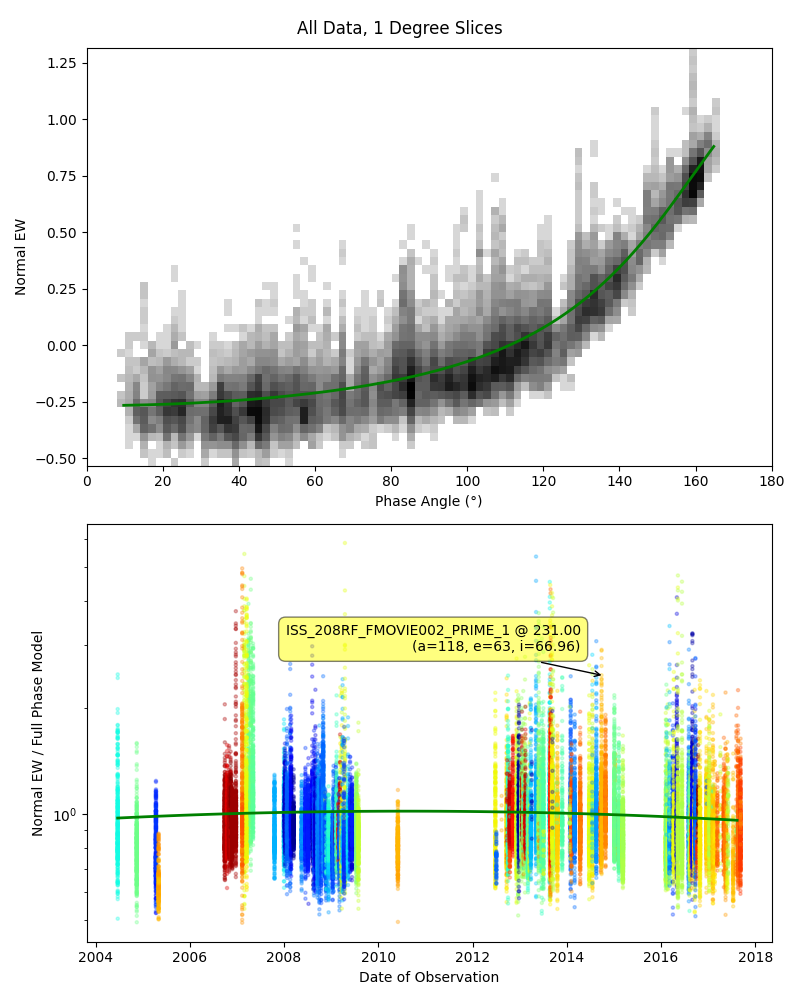

In [8]:
plot_heatmap_phase_curve_time(obsdata_0_1, params_0_1, 
                              'All Data, 1 Degree Slices', time_fit=2)

<IPython.core.display.Javascript object>


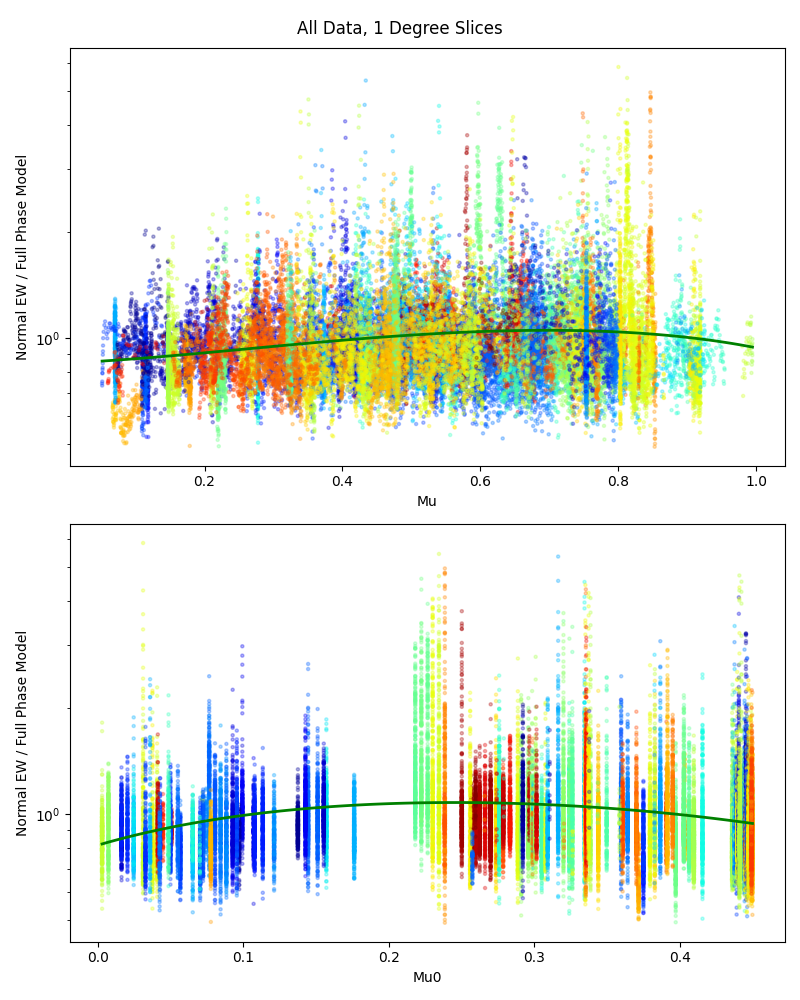

In [6]:
plot_ratio_vs_mu_mu0(obsdata_0_1, params_0_1, 
                     'All Data, 1 Degree Slices', order=3)

<IPython.core.display.Javascript object>


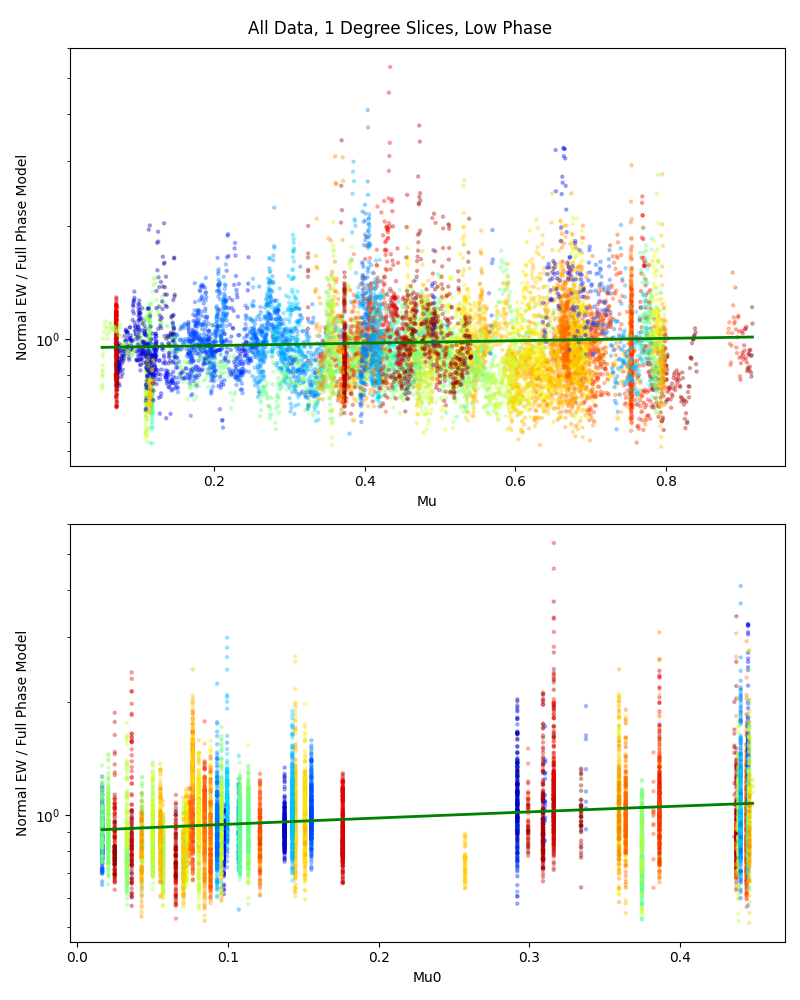

In [7]:
obsdata_0_1_low_phase = obsdata_0_1[obsdata_0_1['Mean Phase'] <= 60].copy()
# obsdata_0_1_low_ei = obsdata_0_1_low_phase[((obsdata_0_1_low_phase['Mean Emission']-90).abs() <= 6) |
#                                             (obsdata_0_1_low_phase['Incidence'] >= 84)].copy()
plot_ratio_vs_mu_mu0(obsdata_0_1_low_phase, params_0_1, 
                     'All Data, 1 Degree Slices, Low Phase', order=1)